In [73]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# APEX Gun example

In [328]:
import sys, os
root = os.path.join(os.getcwd(), '../')

sys.path.append(root)

INPUT_FILE = os.path.join(root,'templates/apex_gun/gpt.in')

from gpt import GPT

In [329]:
G = GPT(input_file=INPUT_FILE, verbose=True)

Configured to run in /var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmptisynboy


In [326]:
# Set some of these
variables_were_set = G.set_variables({'gun_peak_field':20e6,'gun_phase':90,'tmax':5e-9, 'RadiusMax':0.01})
print(variables_were_set)

[True, True, True, True]


In [322]:
# Run
G.run()
print(G)
print('\nNumber of touts:',len(G.tout))

init dir:  /Users/colwyngulliford/Documents/GitHub/lume-gpt/examples
running GPT in /private/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmp3wxe8aqx

General Particle Tracer - Oct 28 2014
GPT object:
   Original input file: gpt.in
   Use temp directory: True
   Work directory: None

Run Control
   Run configured: True
   Using temp directory: False
   Timeout: None (sec)

Results
   Finished: True
   Error occured: False
   Run time: 0.20273184776306152 (sec)

Number of touts: 23


# Plot trajectories

In [323]:
import numpy as np
from matplotlib import pyplot as plt

# Make trajector structure here for now, should go somewhere else as a function

rs ={}
for t in G.tout:

    for ID in t['ID']:
        idint=int(ID)
        res = np.where(t['ID']==ID)
        index = res[0][0]
        
        if(ID not in rs.keys()):
            rs[idint]={'x':[],'y':[],'z':[]}
        else:
            rs[idint]['x'].append(t['x'][index])
            rs[idint]['y'].append(t['y'][index])
            rs[idint]['z'].append(t['z'][index])
         

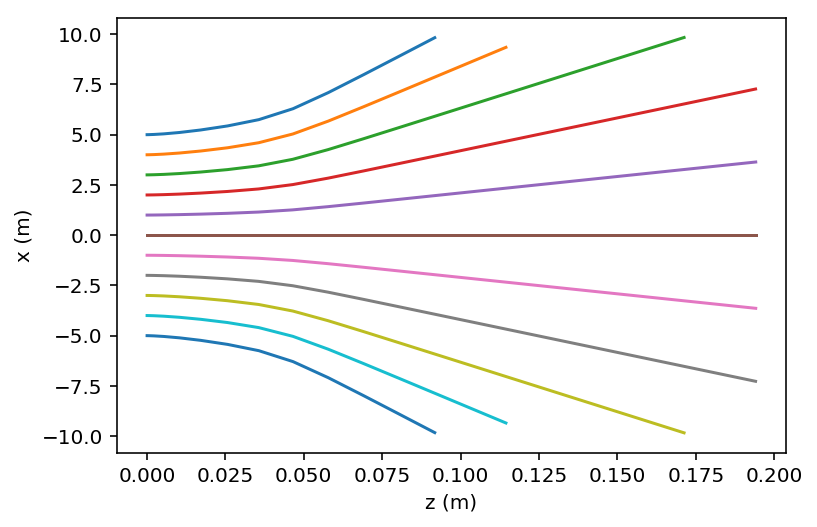

In [325]:
for ind in rs.keys():
    for var in rs[ind]:
        rs[ind][var]=np.array(rs[ind][var])

for ind in rs.keys():
    plt.plot(rs[ind]['z'],rs[ind]['x']*1e3)
    
plt.xlabel('z (m)');
plt.ylabel('x (m)');